In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import seaborn as sns
from sklearn.cluster import KMeans,DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_samples, rand_score, silhouette_score, davies_bouldin_score, adjusted_rand_score, calinski_harabasz_score
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import plotly.express as px
from statistics import mean
from scipy.spatial.distance import cdist
from sklearn.datasets import make_blobs, make_moons, make_circles

# Problem 1

## 1a. Kmeans

In [2]:
# Data is loaded and converted to Dataframe for easier manipulation
df = np.load("x1_vals.npy")
data = pd.DataFrame(df, columns=["ColA", "ColB"])

In [3]:
# Data is scaled
std_scaler = StandardScaler()
data = pd.DataFrame(std_scaler.fit_transform(data[['ColA', 'ColB']]), columns= ['ColA', 'ColB'])

In [4]:
# Basic data is shown, as well as a sample of the first few rows
print(data.info())
data.head(n=5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ColA    750 non-null    float64
 1   ColB    750 non-null    float64
dtypes: float64(2)
memory usage: 11.8 KB
None


ColA      ColB
0 -1.437393 -1.166966
1 -1.303608 -1.252367
2 -0.515689 -0.309900
3 -1.773017 -1.043845
4 -1.004362 -1.412992

In [5]:
# Basic statistical data is obtained, such as the mean, standard deviation, and the quartiles
data.describe().T

count          mean       std       min       25%       50%       75%  \
ColA  750.0  2.463215e-16  1.000667 -1.805776 -0.895370 -0.152225  1.070603   
ColB  750.0 -1.818989e-15  1.000667 -2.160756 -1.013316  0.237937  0.828886   

           max  
ColA  1.894078  
ColB  2.299018

In [6]:
# It can be observed that there are no missing values
data.isna().sum()

ColA    0
ColB    0
dtype: int64

<Axes: xlabel='ColA', ylabel='ColB'>

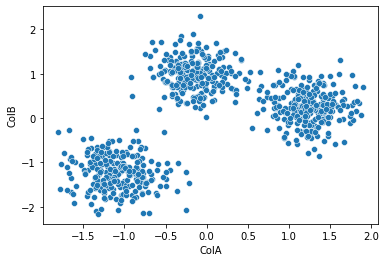

In [7]:
# Scatterplot to see the relationship between the columns
sns.scatterplot(data=data, x = "ColA", y = "ColB")

It can be seen that the data could be split in 3 clusters, with little intersection between them. 

<Axes: xlabel='ColA', ylabel='ColB'>

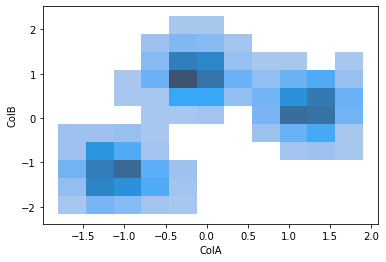

In [8]:
sns.histplot(data=data, x = "ColA", y = "ColB")

In a similar graph, we can estimate the centroid for each cluster, and how the outlier elements for each clustere have little overlap with each other

Another method is the elbow method. 
When an "elbow" is formed in the plot, that is the number of clusters that should be used. 

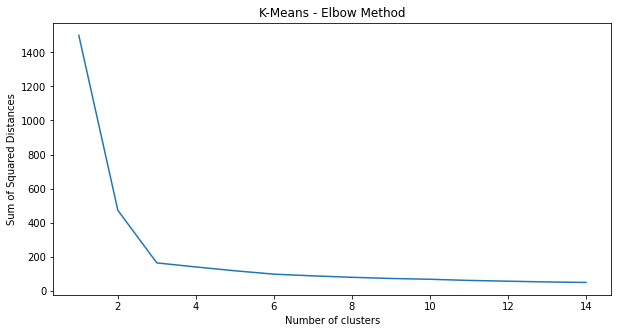

In [9]:
sum_sqrd_full = []
for k in range(1,15):
    kmeans = KMeans(n_clusters = k, init='random',random_state=0, n_init="auto")
    kmeans.fit(data)
    sum_sqrd_full.append(kmeans.inertia_)
plt.figure(figsize=(10,5))
plt.plot(range(1,15),sum_sqrd_full)
plt.title("K-Means - Elbow Method")
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Distances')
plt.show()

It can be seen that the "elbow" is formed on 3, which is the estimated number of clusters in the data. 

One more method to determine the number of clusters is using silhouette analysis

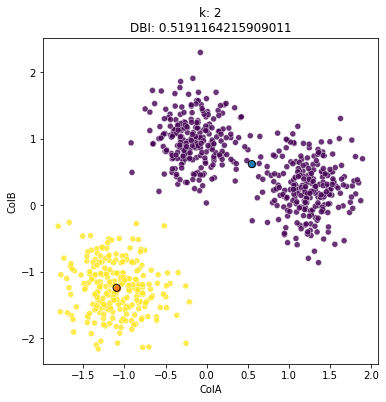

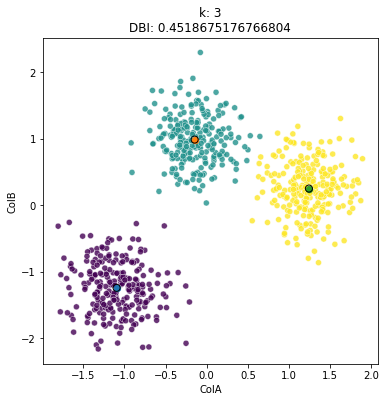

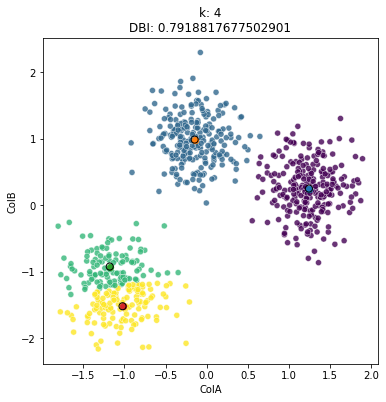

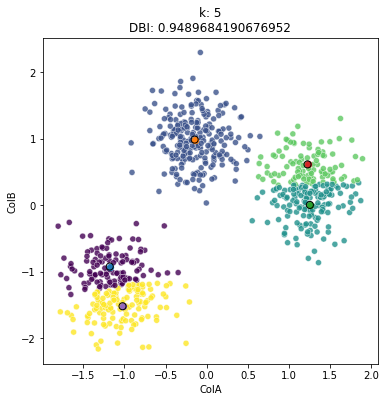

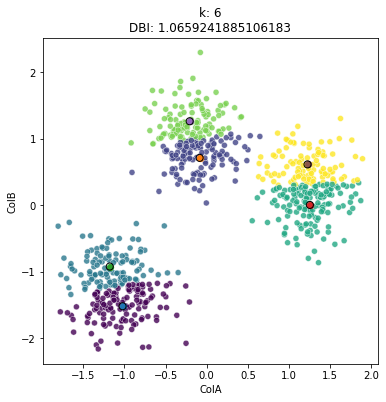

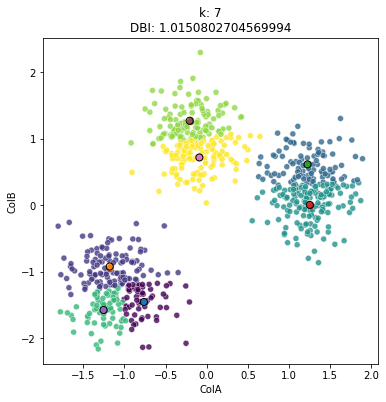

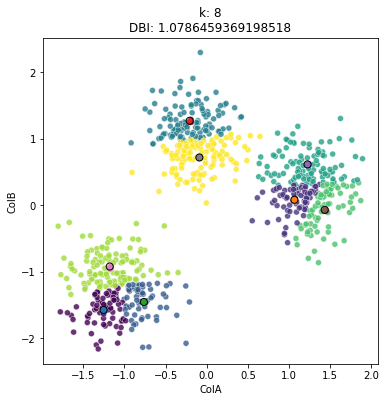

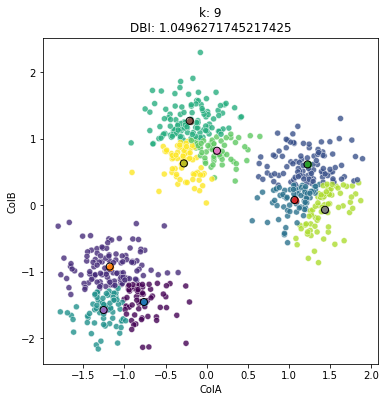

In [10]:
# Evaluation method: Davies-Bouldin Index
X = data.copy()
for n_cluster in np.arange(2, 10):
    kmeans = KMeans(n_clusters = n_cluster, init='random',random_state=0, n_init="auto")
    kmeans.fit(X)
    centers = kmeans.cluster_centers_
    X["label"] = kmeans.labels_

    plt.figure(figsize= (6, 6))
    sns.scatterplot(x= X.ColA, y= X.ColB, c= kmeans.labels_, alpha= 0.8)
    for j in np.arange(len(centers)):
        plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 40)
        plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 50, edgecolors= 'black', facecolors= 'none')
    plt.title(f'k: {n_cluster}\nDBI: {davies_bouldin_score(X= X[["ColA", "ColB"]], labels= X.label)    }')
    plt.show()

It can be seen with the Davies-Bouldin index evaluation that the right number of clusters is 3. 

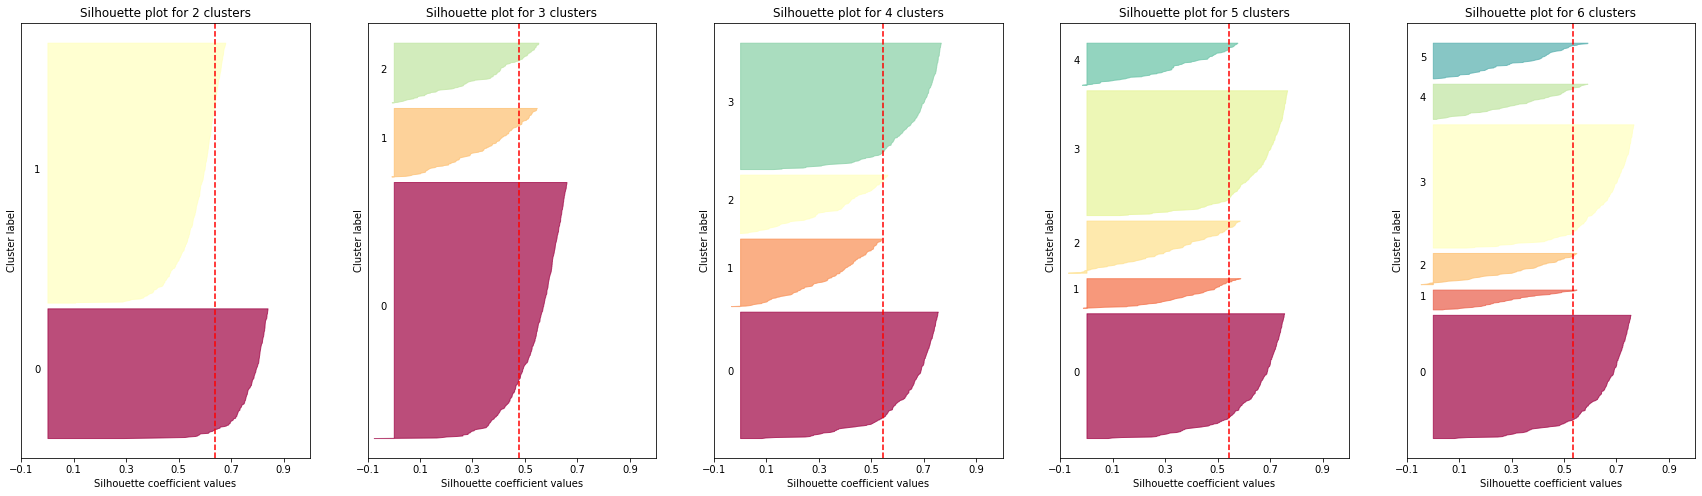

In [11]:
# Range of values for k

X = data.copy()
range_n_clusters = [2, 3, 4, 5, 6]

plt.figure(figsize=(len(range_n_clusters) * 6, 8))

for i, n_clusters in enumerate(range_n_clusters):
    # Initialize the clusterer
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init = "auto")
    cluster_labels = clusterer.fit_predict(X)

    # Compute the silhouette scores
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    plt.subplot(1, len(range_n_clusters), i + 1)
    y_lower = 10

    for j in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]
        ith_cluster_silhouette_values.sort()
        size_cluster_j = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j

        color = colormaps["Spectral"](float(j) / n_clusters) #plt.cm.get_cmap("Spectral")(float(j) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
        y_lower = y_upper + 10

    plt.title("Silhouette plot for {} clusters".format(n_clusters))
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.yticks([])
    plt.xticks(np.arange(-0.1, 1.1, 0.2))
    plt.xlim([-0.1, 1.0])

plt.show()

If we use only the coefficient values as the choosing factor, then k=2 is the best choice. 
However, we can see through the scatterplot that the number of clusters is probably 3. 
Then, k=3 has its 3 clusters above the average, but with the lowest coefficient value. 
Similar results for k=4, 5, and 6. 
This test is inconclusive.

In [12]:
# Fitting a K-means model
k = 3 # Number of clusters that was previously determined in the elbow method and the graphical methods, 
# as well as the Davies-Bouldin index method. 
kmeans = KMeans(n_clusters = k, init='random',random_state=0, n_init="auto")
kmeans.fit(data)

KMeans(init='random', n_clusters=3, n_init='auto', random_state=0)

In [13]:
labels = kmeans.labels_

In [14]:
# Centers of the clusters
centroids = kmeans.cluster_centers_
centroids

array([[-1.09550672, -1.24100805],
       [-0.14683618,  0.98889946],
       [ 1.24234291,  0.25210859]])

In [15]:
# Iterations to converge
kmeans.n_iter_

5

In [16]:
# Sum of squared distances of samples to their closest cluster center
kmeans.inertia_

163.32659893424147

In [17]:
labeled_data = data.copy()
labeled_data["label"] = kmeans.labels_

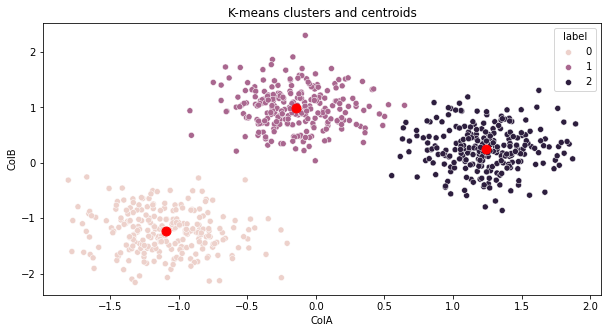

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(data = labeled_data, x = "ColA", y = "ColB", hue = "label", ax = ax)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = "red")
plt.title("K-means clusters and centroids")
plt.show()

### Questions: 
A.	What method(s) did you use to identify an appropriate value for K? Why did you select this method?

Graphical methods, in particular, the scatterplot and the elbow method, which show a very clear picture of the data and how it is clustered.
The elbow method and the silhouette analysis methods were also used, as well as the Davies-Bouldin Score as an evaluation method.
However, the silhouette analysis was inconclusive, and the results of the elbow method and Davies-Bouldin Index were used, which were confirmed with the scatterplot.

B.	What value did you select for K? Does your EDA support this choice?

The value for K is 3, which was decided on the previously mentioned methods

C.	How many iterations were required before your model converged?

5 Iterations

D.	What were the values for each of your cluster centroids?

* -1.09550672, -1.24100805
* -0.14683618,  0.98889946
* 1.24234291,  0.25210859

E.	What kmeans measure serves as a proxy for cluster coherence? What value did your model return? Discuss your interpretation of this value.

Inertia
My model returned 163.3265
The lower the inertia, the better. 
Without comparing the inertia results from this model to another model, it is hard to interpret if the inertia is low enough to be considered good. 

In [19]:
# Fitting a K-means model with a purposely bad number of clusters
k = 4
kmeans = KMeans(n_clusters = k, init='random',random_state=0, n_init="auto")
kmeans.fit(data)

KMeans(init='random', n_clusters=4, n_init='auto', random_state=0)

In [20]:
# Centers of the clusters
centroids = kmeans.cluster_centers_
centroids

array([[ 1.24234291,  0.25210859],
       [-0.14683618,  0.98889946],
       [-1.17907836, -0.92086787],
       [-1.02316113, -1.51814432]])

In [21]:
# Iterations to converge
kmeans.n_iter_

6

In [22]:
# Sum of squared distances of samples to their closest cluster center
kmeans.inertia_

139.6344752603787

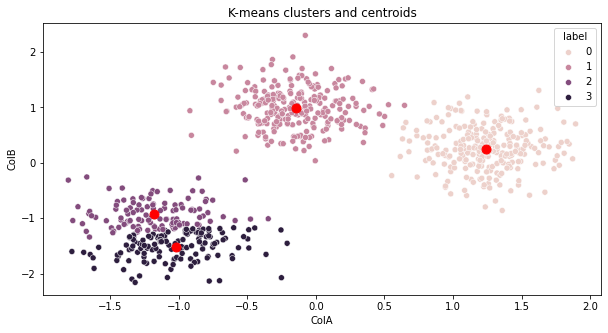

In [23]:
labeled_data = data.copy()
labeled_data["label"] = kmeans.labels_
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(data = labeled_data, x = "ColA", y = "ColB", hue = "label", ax = ax)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = "red")
plt.title("K-means clusters and centroids")
plt.show()

It can be seen that by increasing by one the number of clusters, the intertia is reduced, but the plot of the clusters is not as good as with only 3 clusters.
It was also mentioned in class that it is expected for the inertia to be reduced the higher the number of clusters, as if we were to create a centroid for each data point, the sum of squares would be 0, but it would not be a good clustering. 
Therefore, I believe the result with 3 clusters is appropriate. 

## 1b. Silhouette Plot 

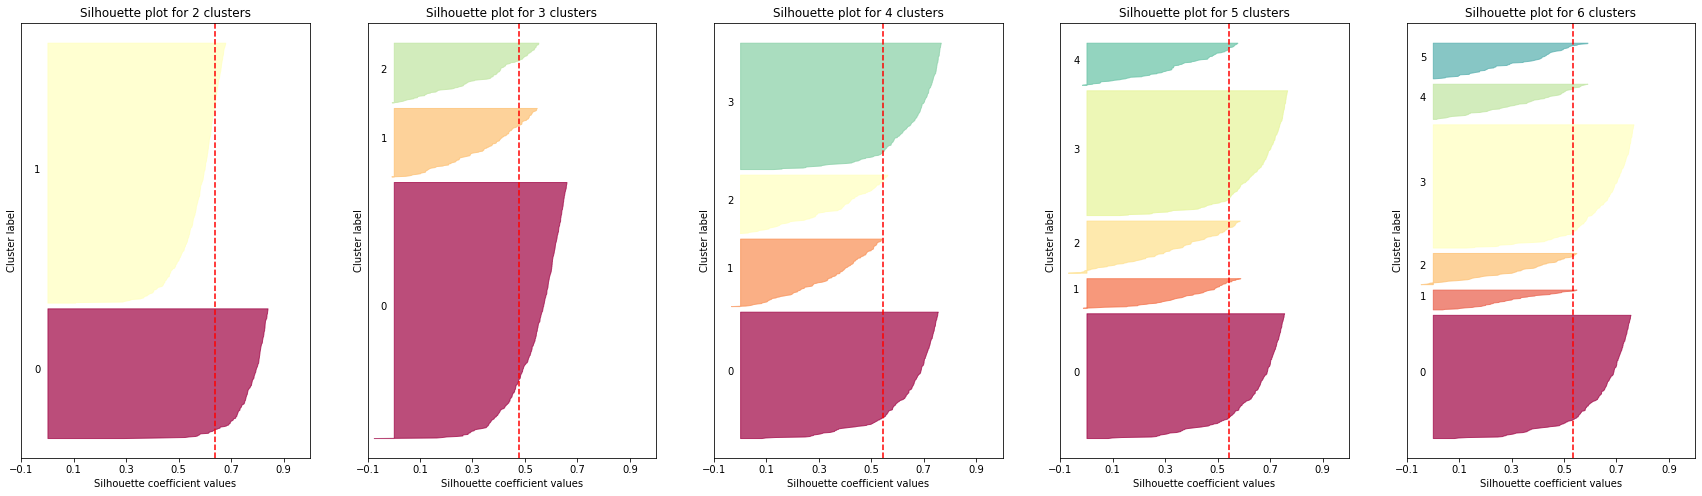

In [24]:
# Range of values for k

X = data.copy()
range_n_clusters = [2, 3, 4, 5, 6]

plt.figure(figsize=(len(range_n_clusters) * 6, 8))

for i, n_clusters in enumerate(range_n_clusters):
    # Initialize the clusterer
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init = "auto")
    cluster_labels = clusterer.fit_predict(X)

    # Compute the silhouette scores
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    plt.subplot(1, len(range_n_clusters), i + 1)
    y_lower = 10

    for j in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]
        ith_cluster_silhouette_values.sort()
        size_cluster_j = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j

        color = colormaps["Spectral"](float(j) / n_clusters) #plt.cm.get_cmap("Spectral")(float(j) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
        y_lower = y_upper + 10

    plt.title("Silhouette plot for {} clusters".format(n_clusters))
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.yticks([])
    plt.xticks(np.arange(-0.1, 1.1, 0.2))
    plt.xlim([-0.1, 1.0])

plt.show()

### Questions
A.	What information does a silhouette analysis provide?

The separation distance between the resulting clusters. 
It displays a measure of how close each point in one cluster is to points in the neighboring clusters.
It is a way to graphically assess the correct number of clusters. 
A very simple summary is that the closer to +1, the better, and the closer to -1, the worse.

B.	Describe how to interpret the individual silhouette plots in terms of cluster cohesion and separation. What are the key features of the graphs that aid your evaluation?

The thickness of the silhouette plots shows the size of the clusters. 
But the most relevant visual aid is the red line, which represents the average silhouette score. 
In the case for clusters = 2, it is the closest to +1, which, as we know, is the best score. 

C.	From the silhouette plots you created, what value of K affords the best cluster assignments?

K = 2

However, as we can see from the scatterplot, this is not the correct answer. 

# Problem 2: External Validation

In [25]:
# The data is created
k = 5
X, y = make_blobs(n_samples=2500, centers=k, n_features=2,random_state=0)

In [26]:
df = pd.DataFrame(X, columns=["ColA", "ColB"])
std_scaler = StandardScaler()
df = pd.DataFrame(std_scaler.fit_transform(df), columns= ['ColA', 'ColB'])
df["label"] = y

<Axes: xlabel='ColA', ylabel='ColB'>

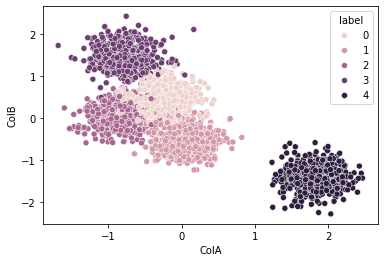

In [27]:
# Clusters and their distributions
sns.scatterplot(data = df, x = "ColA", y = "ColB", hue = "label")

In [28]:
# The K means model is created and trained
kmeans = KMeans(n_clusters = k, init='random',random_state=0, n_init="auto")
kmeans.fit(df[['ColA', 'ColB']])

KMeans(init='random', n_clusters=5, n_init='auto', random_state=0)

In [29]:
df["predicted"] = kmeans.labels_

<Axes: xlabel='ColA', ylabel='ColB'>

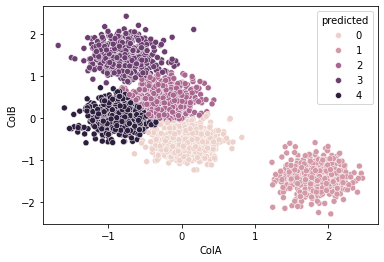

In [30]:
sns.scatterplot(data = df, x = "ColA", y = "ColB", hue = "predicted")

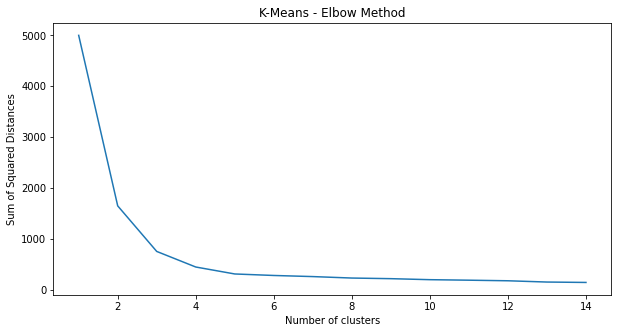

In [31]:
sum_sqrd_full = []
for k in range(1,15):
    kmeans = KMeans(n_clusters = k, init='k-means++',random_state=0, n_init="auto")
    kmeans.fit(df[['ColA', 'ColB']])
    sum_sqrd_full.append(kmeans.inertia_)
plt.figure(figsize=(10,5))
plt.plot(range(1,15),sum_sqrd_full)
plt.title("K-Means - Elbow Method")
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Distances')
plt.show()

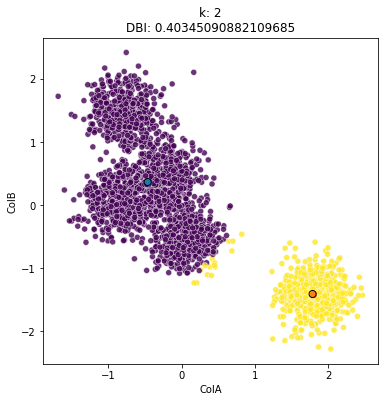

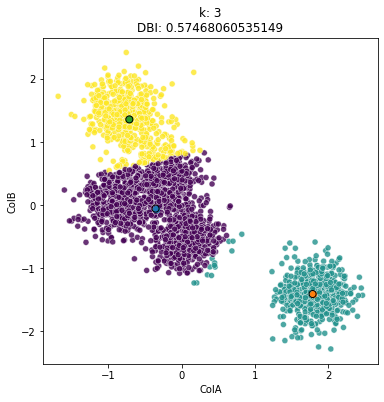

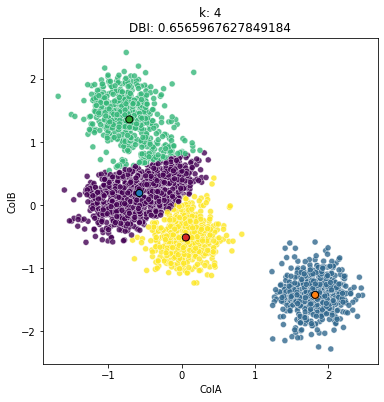

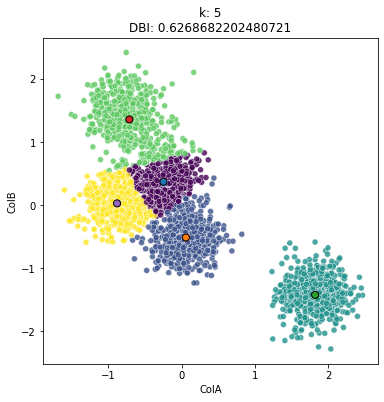

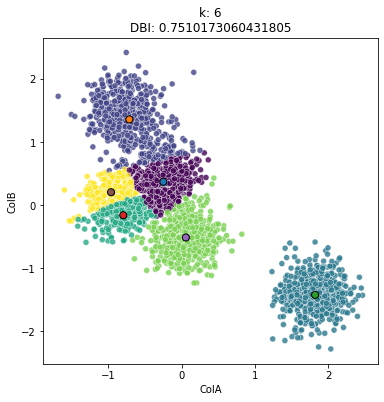

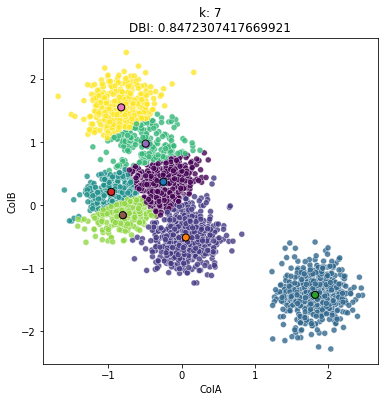

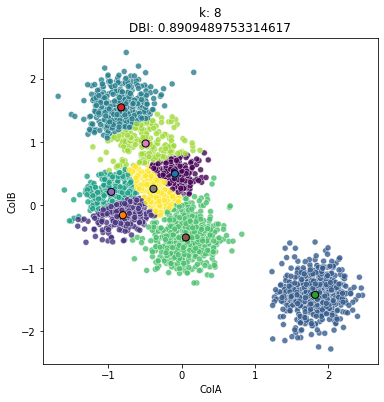

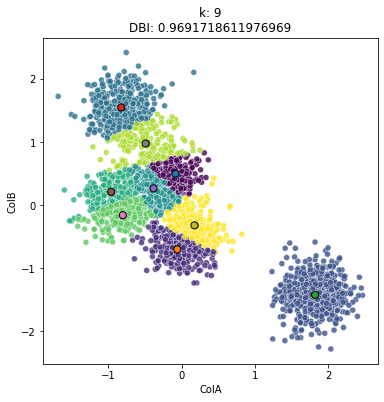

In [32]:
# Evaluation method: Davies-Bouldin Index
data = pd.DataFrame(df[['ColA', 'ColB']], columns=["ColA", "ColB"])
for k in np.arange(2, 10):
    kmeans = KMeans(n_clusters= k, n_init= 'auto', random_state=42)
    kmeans.fit(data)
    centers = kmeans.cluster_centers_
    data["label"] = kmeans.labels_

    plt.figure(figsize= (6, 6))
    sns.scatterplot(x= data.ColA, y= data.ColB, c= kmeans.labels_, alpha= 0.8)
    for j in np.arange(len(centers)):
        plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 40)
        plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 50, edgecolors= 'black', facecolors= 'none')
    plt.title(f'k: {k}\nDBI: {davies_bouldin_score(X= data[["ColA", "ColB"]], labels= data.label)    }')
    data.drop(["label"], axis=1)
plt.show()

By using the Davies-Bouldin index, it can be seen that the best estimate for number of clusters is K = 2. However, as we are the ones that created this data, we know that the correct number of clusters is 5, which has the highest DBI score. 
Another method will need to be used.

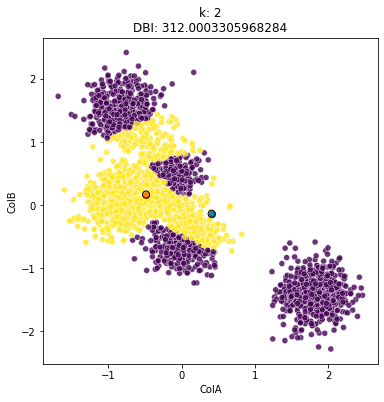

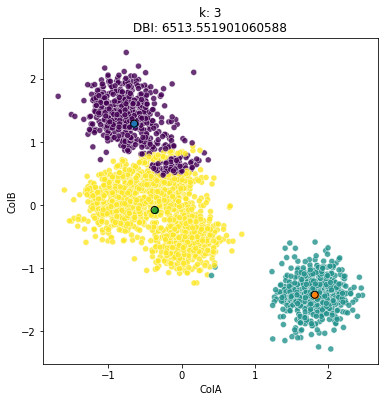

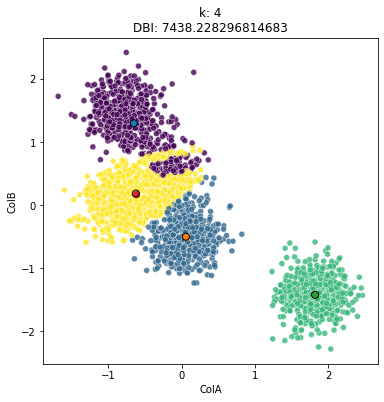

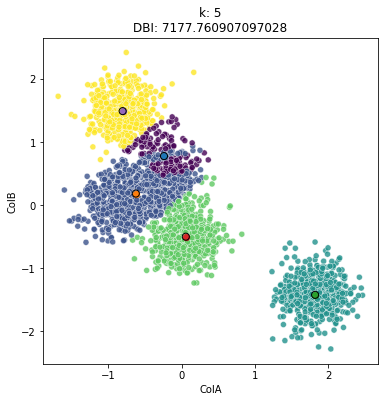

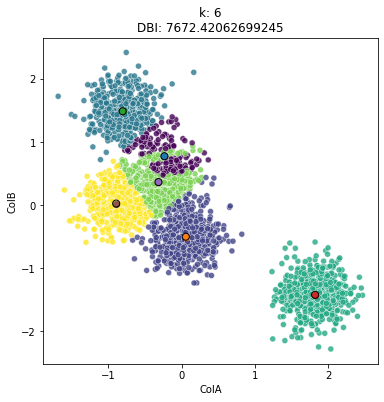

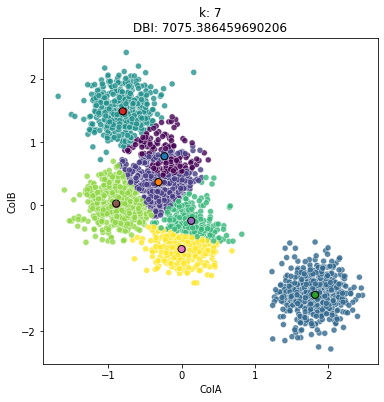

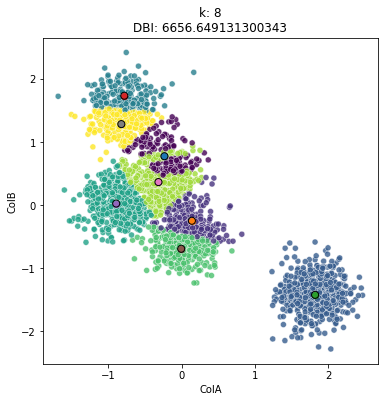

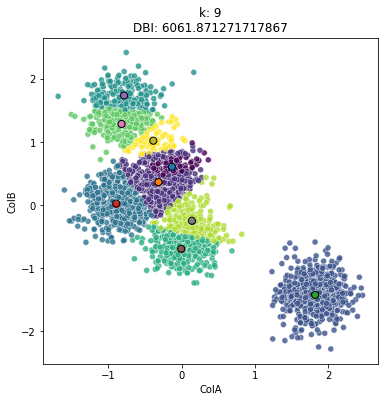

In [33]:
# Calinski-Harabasz score
cluster_numbers = np.arange(2,10)
chs = []
for k in np.arange(2, 10):
    kmeans = KMeans(n_clusters= k, n_init= 'auto', random_state=42)
    kmeans.fit(data)
    centers = kmeans.cluster_centers_
    data["label"] = kmeans.labels_

    plt.figure(figsize= (6, 6))
    sns.scatterplot(x= data.ColA, y= data.ColB, c= kmeans.labels_, alpha= 0.8)
    for j in np.arange(len(centers)):
        plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 40)
        plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 50, edgecolors= 'black', facecolors= 'none')
    score = calinski_harabasz_score(X= data[["ColA", "ColB"]], labels= data.label)
    chs.append(score)
    plt.title(f'k: {k}\nDBI: {score}')
    data.drop(["label"], axis=1)
plt.show()

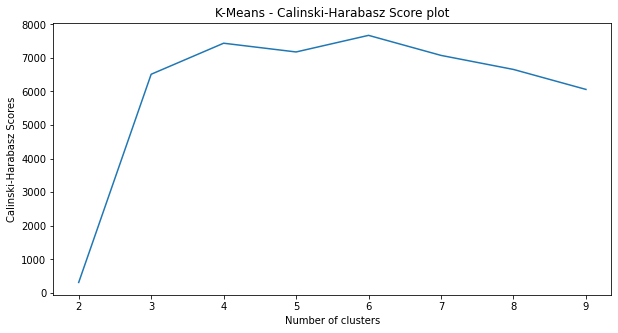

In [34]:
plt.figure(figsize=(10,5))
plt.plot(cluster_numbers,chs)
plt.title("K-Means - Calinski-Harabasz Score plot")
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Scores')
plt.show()

It can be observed that when clusters = 6, the CH score is the highest, as well as an "elbow" is formed on the plot. 
Using the CH score, we could decide that the appropiate number of clusters is 6. 

Clusters: 2, score: 0.48186321682237465
Clusters: 3, score: 0.3706100096574708
Clusters: 4, score: 0.4289672526296921
Clusters: 5, score: 0.6638034913545653
Clusters: 6, score: 0.716032178954736


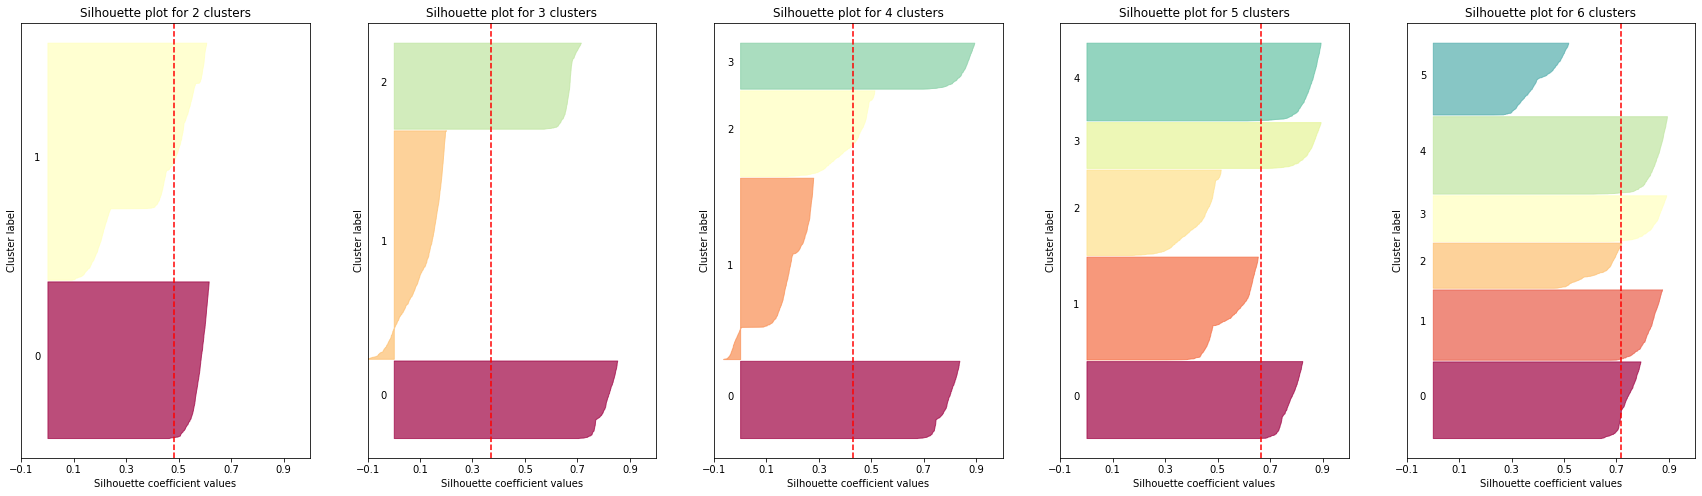

In [35]:
X = data.copy()
range_n_clusters = [2, 3, 4, 5, 6]

plt.figure(figsize=(len(range_n_clusters) * 6, 8))

for i, n_clusters in enumerate(range_n_clusters):
    # Initialize the clusterer
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init = "auto")
    cluster_labels = clusterer.fit_predict(X)

    # Compute the silhouette scores
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    plt.subplot(1, len(range_n_clusters), i + 1)
    y_lower = 10

    for j in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]
        ith_cluster_silhouette_values.sort()
        size_cluster_j = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j

        color = colormaps["Spectral"](float(j) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
        y_lower = y_upper + 10

    plt.title("Silhouette plot for {} clusters".format(n_clusters))
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")
    print("Clusters: {}, score: {}".format(n_clusters, silhouette_avg))
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.yticks([])
    plt.xticks(np.arange(-0.1, 1.1, 0.2))
    plt.xlim([-0.1, 1.0])

plt.show()

The highest average is when clusters = 6, and it is the only choice with a high coefficient where none of the clusters is below average. 
Results: 
* Calinski-Harabasz score: 6
* Davies-Bouldin score: 2
* silhouette scores: 6

The results are inconclusive with tests to decide the number of clusters.

In [36]:
# Calculating the adjusted rand score
adjusted_rand_score(df["label"], df["predicted"])

0.8705269925953999

In [37]:
# Calculating the rand score
rand_score(df["label"], df["predicted"])

0.9586160864345739

## Questions
A.	what method did you select to assess cluster agreement and why?

First, the number of clusters was estimated as in the previous exercise.

* Davies-Bouldin score: It measures how similar a cluster is to the most similar cluster to it. The lower, the better.
* Calinski-Harabasz score: measures the ratio of the sum of inter-cluster dispersion and the sum of intra-cluster dispertion. The higher, the better.
* Silhouette score: It measures how close each point in one cluster is to points in the neighboring clusters. The closer to +1, the better. 

Afterwards, to put a score on the clustering, the Rand index was chosen.
It returned a score of 0.87, where 0 is completely wrong, and 1 is perfect. 

B.	What do your results of this assessment suggest?
Estimating the clusters:
The results are conflicting, as two of the measures result in the appropiate number of clusters being 2, and five being a poor selection, while another measurement says that 5 is the appropiate number of clusters. 

Clustering evaluation: 

Adjusted Rand index: 0.87
Rand index: 0.95

It can be seen that despite the estimation of the number of clusters was left inconclusive, the evaluation metrics clearly show that the model performed well.

# Problem 3

## 3a. Concepts: Interpreting SSE

Total SSE is the sum of the SSE for each separate attribute in the Kmeans algorithm. 
* What does it mean if the SSE for one variable is low for all clusters? 

This may mean that this variable is a good separator for the clusters, and is a good way to split the clusters

* Low for just one cluster? 

It suggests that this variable may be a good separator of the data for this specific cluster, but this may not apply for other clusters. But it also suggests that if it is low for just one cluster, then it is high for every other cluster, so it should not be taken into consideration for the general clustering

* High for all clusters? 

This variable is not a good separator of the data for any clusters, so it should not be taken into consideration for the clustering

* High for just one cluster? 

It may indicate that if it is high for just one cluster, it is low for every other cluster, so it should be used as a data separator for the clustering

* How could you use the per variable SSE information to improve your clustering? 

It could help us to not take into consideration variables with a high SSE and use variables with low SSE.

## 3d. Entropy vs. SSE

Entropy: Measures the level of disorder or uncertainty in a given dataset or system. It measures how well a clustering model split different classes.
SSE: Statistical measure of variability. Measures the distance of each point to the center of the cluster. 

So, entropy focuses more on how similar the points in a cluster are to each other, while the SSE focuses more on how compact the cluster is. 
So it is possible for SSE to judge C1 as a "worse" cluster than C2. 

# Problem 4. Selecting an Appropriate Clustering Algorithm

In [38]:
# Data is loaded and converted to Dataframe for easier manipulation
data = np.load("x4_vals.npy")
data = pd.DataFrame(data, columns=["ColA", "ColB"])

In [39]:
# Data is scaled
std_scaler = StandardScaler()
data = pd.DataFrame(std_scaler.fit_transform(data), columns= ['ColA', 'ColB'])

In [40]:
# Basic data is shown, as well as a sample of the first few rows
print(data.info())
data.head(n=5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ColA    500 non-null    float64
 1   ColB    500 non-null    float64
dtypes: float64(2)
memory usage: 7.9 KB
None


ColA      ColB
0 -1.371927 -0.451673
1 -1.232381 -1.558762
2 -0.880869 -0.783374
3 -1.093064 -1.309323
4 -0.835648 -1.474836

In [41]:
# Basic statistical data is obtained, such as the mean, standard deviation, and the quartiles
data.describe().T

count          mean       std       min       25%       50%       75%  \
ColA  500.0 -2.415845e-16  1.001002 -1.673046 -0.779196 -0.350548  0.844289   
ColB  500.0  3.126388e-15  1.001002 -3.173256 -0.742284  0.318325  0.704125   

           max  
ColA  2.387942  
ColB  2.520272

In [42]:
# It can be observed that there are no missing values
data.isna().sum()

ColA    0
ColB    0
dtype: int64

<Axes: xlabel='ColA', ylabel='ColB'>

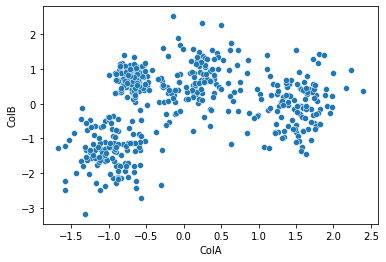

In [43]:
# Scatterplot to see the relationship between the columns
sns.scatterplot(data=data, x = "ColA", y = "ColB")

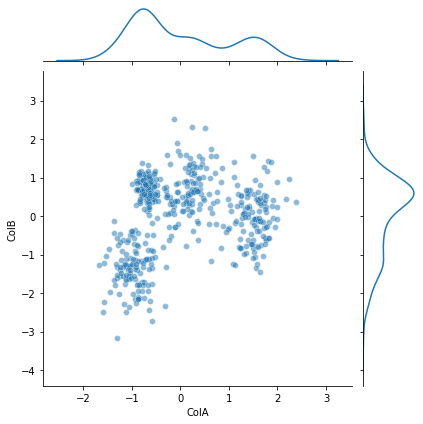

In [44]:
g = sns.JointGrid(data= data, x = "ColA", y = "ColB", height= 6)
g.plot_joint(sns.scatterplot, alpha=.5)
g.plot_marginals(sns.kdeplot);

## K means

### Choosing K

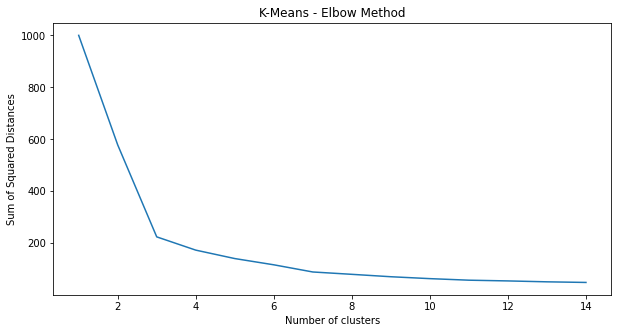

In [45]:
# Elbow method
sum_sqrd_full = []
for k in range(1,15):
    kmeans = KMeans(n_clusters = k, init='k-means++',random_state=0, n_init="auto")
    kmeans.fit(data)
    sum_sqrd_full.append(kmeans.inertia_)
plt.figure(figsize=(10,5))
plt.plot(range(1,15),sum_sqrd_full)
plt.title("K-Means - Elbow Method")
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Distances')
plt.show()

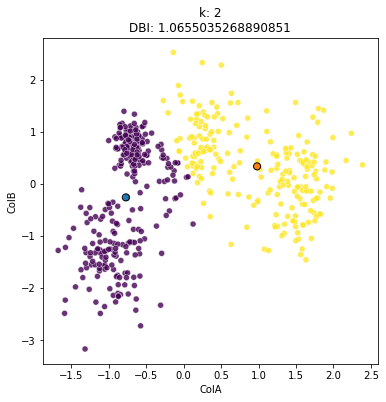

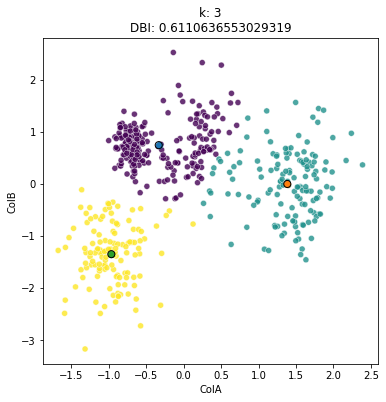

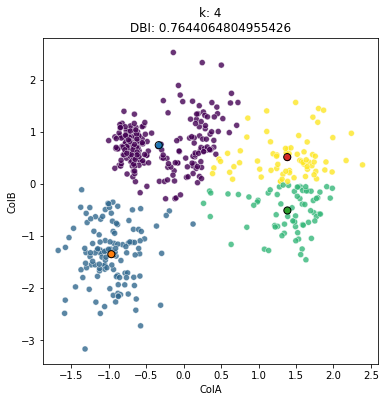

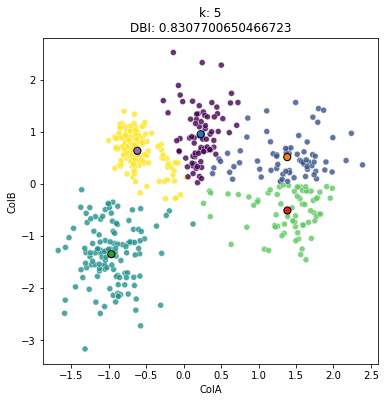

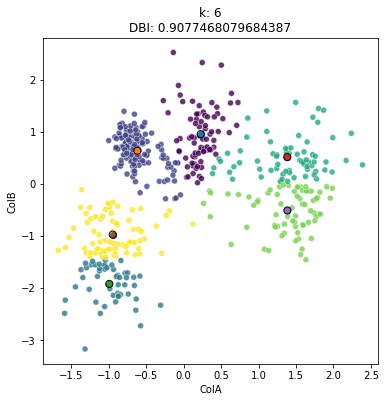

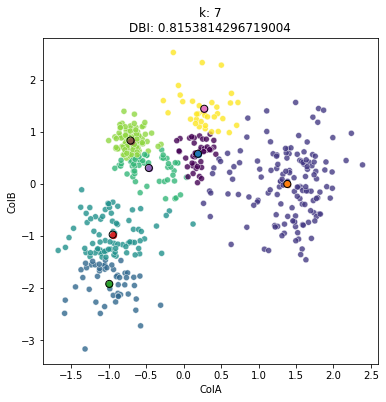

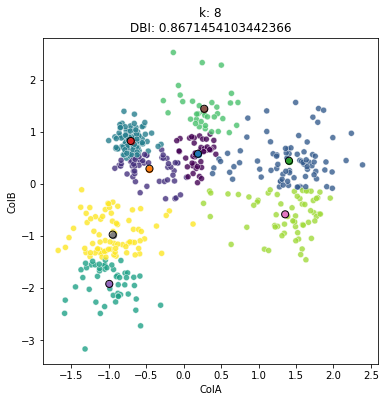

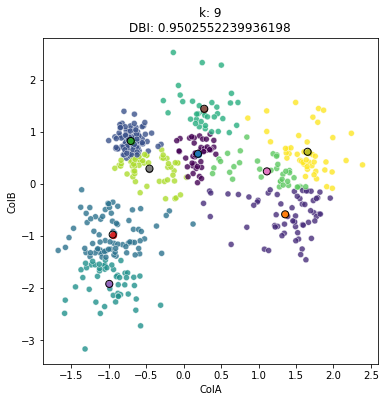

In [46]:
# Davies-Bouldin Index
dbi_data = data.copy()
for k in np.arange(2, 10):
    kmeans = KMeans(n_clusters= k, n_init= 'auto', random_state=0)
    kmeans.fit(dbi_data)
    centers = kmeans.cluster_centers_
    dbi_data["label"] = kmeans.labels_

    plt.figure(figsize= (6, 6))
    sns.scatterplot(x= dbi_data.ColA, y= dbi_data.ColB, c= kmeans.labels_, alpha= 0.8)
    for j in np.arange(len(centers)):
        plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 40)
        plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 50, edgecolors= 'black', facecolors= 'none')
    plt.title(f'k: {k}\nDBI: {davies_bouldin_score(X= dbi_data[["ColA", "ColB"]], labels= dbi_data.label)    }')
plt.show()

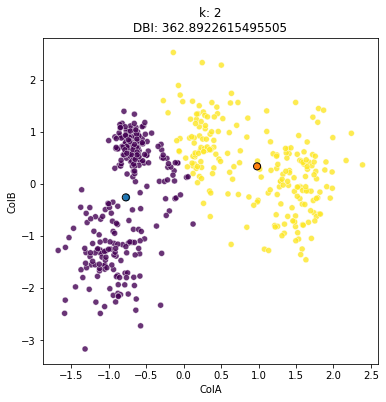

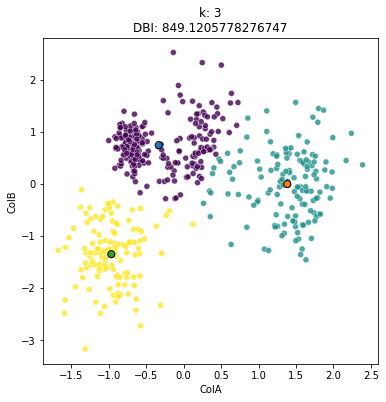

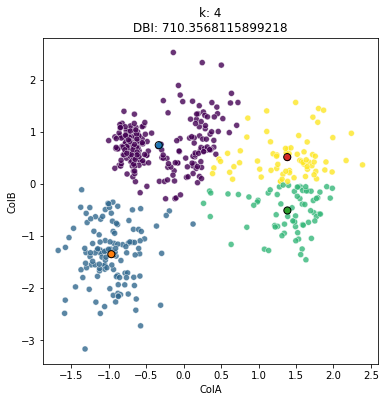

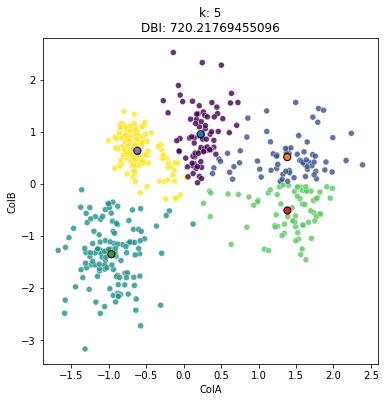

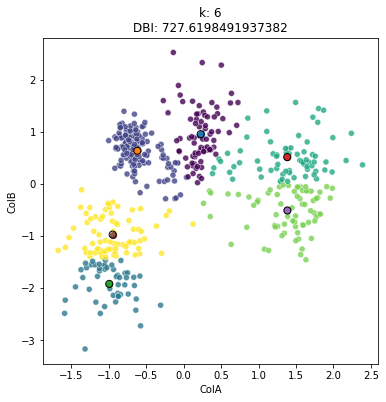

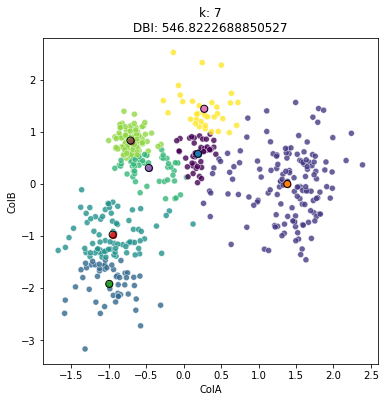

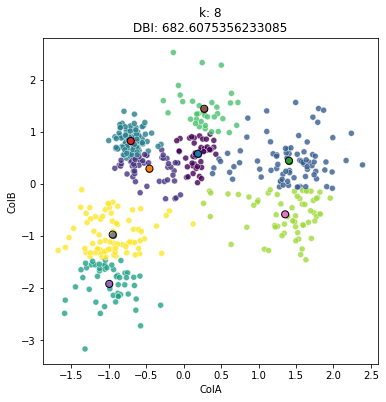

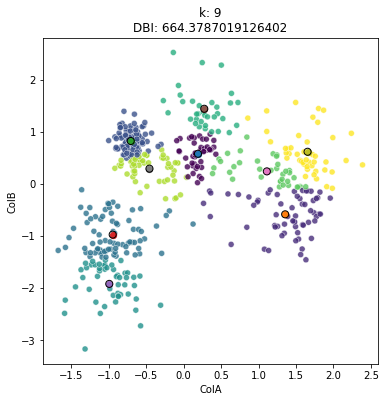

In [47]:
# Calinski-Harabasz score
cluster_numbers = np.arange(2,10)
chs = []
ck_data = data.copy()
for k in np.arange(2, 10):
    kmeans = KMeans(n_clusters= k, n_init= 'auto', random_state=0)
    kmeans.fit(ck_data)
    centers = kmeans.cluster_centers_
    ck_data["label"] = kmeans.labels_

    plt.figure(figsize= (6, 6))
    sns.scatterplot(x= ck_data.ColA, y= ck_data.ColB, c= kmeans.labels_, alpha= 0.8)
    for j in np.arange(len(centers)):
        plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 40)
        plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 50, edgecolors= 'black', facecolors= 'none')
    score = calinski_harabasz_score(X= ck_data[["ColA", "ColB"]], labels= ck_data.label)
    chs.append(score)
    plt.title(f'k: {k}\nDBI: {score}')
plt.show()

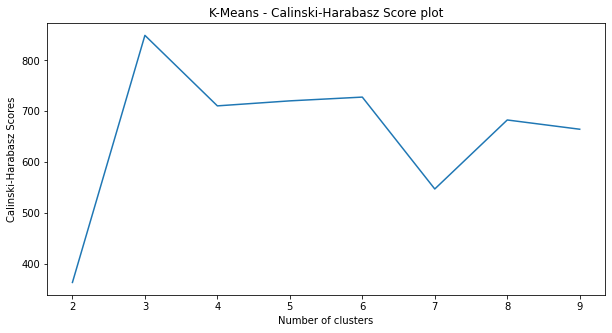

In [48]:
plt.figure(figsize=(10,5))
plt.plot(cluster_numbers,chs)
plt.title("K-Means - Calinski-Harabasz Score plot")
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Scores')
plt.show()

Clusters: 2, score: 0.402487293250036
Clusters: 3, score: 0.5718560352460762
Clusters: 4, score: 0.5035401232332255
Clusters: 5, score: 0.5103152605902256
Clusters: 6, score: 0.46560185691693273


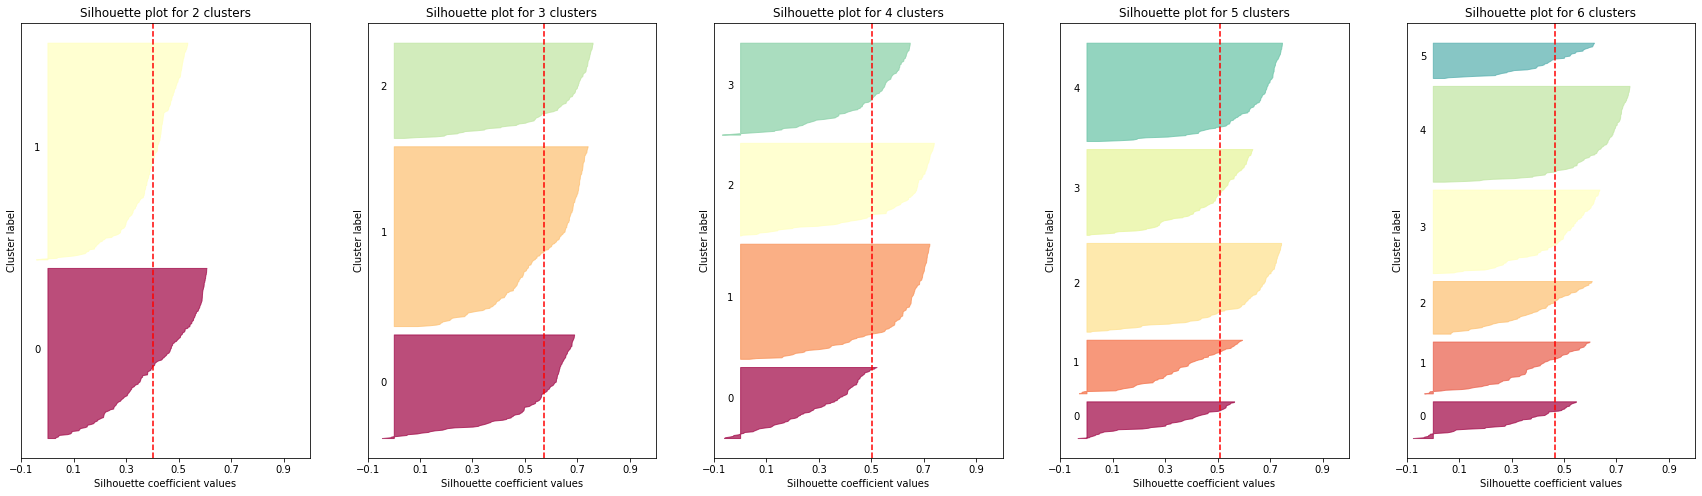

In [49]:
# Silhouette scores
X = data.copy()
range_n_clusters = [2, 3, 4, 5, 6]

plt.figure(figsize=(len(range_n_clusters) * 6, 8))

for i, n_clusters in enumerate(range_n_clusters):
    # Initialize the clusterer
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init = "auto")
    cluster_labels = clusterer.fit_predict(X)

    # Compute the silhouette scores
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    plt.subplot(1, len(range_n_clusters), i + 1)
    y_lower = 10

    for j in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]
        ith_cluster_silhouette_values.sort()
        size_cluster_j = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j

        color = colormaps["Spectral"](float(j) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
        y_lower = y_upper + 10

    plt.title("Silhouette plot for {} clusters".format(n_clusters))
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")
    print("Clusters: {}, score: {}".format(n_clusters, silhouette_avg ))

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.yticks([])
    plt.xticks(np.arange(-0.1, 1.1, 0.2))
    plt.xlim([-0.1, 1.0])

plt.show()

Results: 
* Elbow method: It can be seen that the right number of clusters should be 3
* Davies-Bouldin Index: It can be seen that the right number of clusters is 3
* Calinski-Harabasz score: The right number is 3
* Silhouette score: The right number is 3 clusters

In [50]:
n_clusters = 3

In [51]:
data_res = data.copy()
data_res["labels"] = KMeans(n_clusters = n_clusters, random_state = 0, n_init="auto").fit_predict(data_res)

[Text(0.5, 1.0, 'Kmeans')]

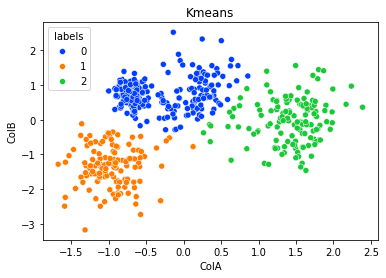

In [52]:
sns.scatterplot(data=data_res,x="ColA",y='ColB', hue='labels', palette='bright').set(title='Kmeans')

## Gaussian Mixture Model

### Choosing K

In [53]:
# Davies-Bouldin Index
for k in np.arange(2, 10):
    gm = GaussianMixture(n_components=k, random_state=0)
    gm.fit(data)
    print(f'k: {k}\nDBI: {davies_bouldin_score(X= data[["ColA", "ColB"]], labels= gm.predict(data))    }')


k: 2
DBI: 1.1223822350572235
k: 3
DBI: 0.6044744671720729
k: 4
DBI: 0.7850721557999039
k: 5
DBI: 0.7981761558633865
k: 6
DBI: 0.8011907915029863
k: 7
DBI: 0.8044598015456943
k: 8
DBI: 0.8400739698196984
k: 9
DBI: 0.8425813055499884


Estimated number of clusters: 3

In [54]:
# Calinski-Harabasz score
cluster_numbers = np.arange(2,10)
chs = []
for k in cluster_numbers:
    gm = GaussianMixture(n_components=k, random_state=0)
    gm.fit(data)
    score = calinski_harabasz_score(X= data[["ColA", "ColB"]], labels = gm.predict(data))
    chs.append(score)
    print(f'k: {k}\nDBI: {score}')

k: 2
DBI: 337.77904126855907
k: 3
DBI: 832.6718760799957
k: 4
DBI: 741.0401393738679
k: 5
DBI: 707.1782853058994
k: 6
DBI: 696.8169164744857
k: 7
DBI: 790.0879491046139
k: 8
DBI: 775.6151348776016
k: 9
DBI: 773.6880682065483


Estimated number of clusters: 3

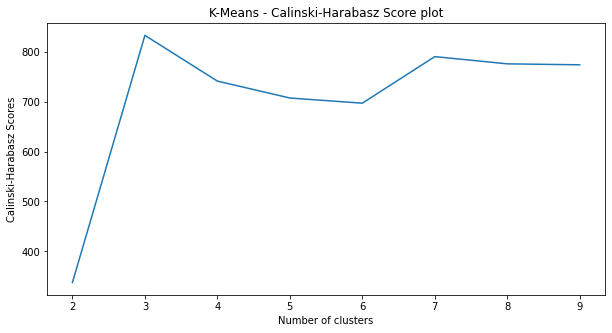

In [55]:
plt.figure(figsize=(10,5))
plt.plot(cluster_numbers,chs)
plt.title("K-Means - Calinski-Harabasz Score plot")
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Scores')
plt.show()

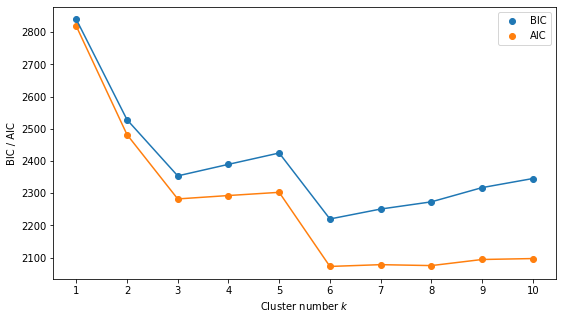

In [56]:
# BIC, AIC
bic_aic = np.empty((0, 3))
for k in np.linspace(1, 10, 10, dtype= int):
    gm = GaussianMixture(n_components= k).fit(data)
    bic_aic = np.vstack([bic_aic, np.array([k, gm.bic(data), gm.aic(data)])]) 
      
plt.figure(figsize= (9, 5))
plt.scatter(x= bic_aic[:, 0], y= bic_aic[:, 1], label= 'BIC')
plt.plot(bic_aic[:, 0], bic_aic[:, 1])
plt.scatter(x= bic_aic[:, 0], y= bic_aic[:, 2], label= 'AIC')
plt.plot(bic_aic[:, 0], bic_aic[:, 2])
plt.xlabel('Cluster number $k$')
plt.ylabel('BIC / AIC')
plt.xticks(ticks= np.linspace(1, 10, 10, dtype= int))
plt.legend()
plt.show()

The 3 tests above give different results: 
3, 3, and 4 clusters. 
The 2 results will be tested

In [57]:
n_clusters = 3

In [58]:
gm = GaussianMixture(n_components=n_clusters, random_state=0).fit(data)

In [59]:
labels = gm.predict(data)

In [60]:
data_res = data.copy()
data_res["labels"] = labels

[Text(0.5, 1.0, 'Gaussian Mixture Model')]

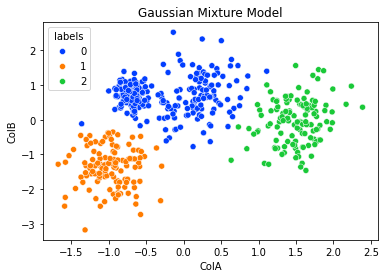

In [61]:
sns.scatterplot(data=data_res,x="ColA",y='ColB', hue='labels', palette='bright').set(title='Gaussian Mixture Model')

In [62]:
n_clusters = 4

In [63]:
gm = GaussianMixture(n_components=n_clusters, random_state=0).fit(data)

In [64]:
labels = gm.predict(data)

In [65]:
data_res = data.copy()
data_res["labels"] = labels

[Text(0.5, 1.0, 'Gaussian Mixture Model')]

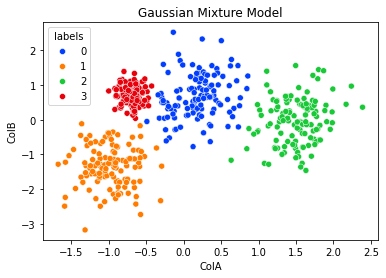

In [66]:
sns.scatterplot(data=data_res,x="ColA",y='ColB', hue='labels', palette='bright').set(title='Gaussian Mixture Model')

## DBSCAN

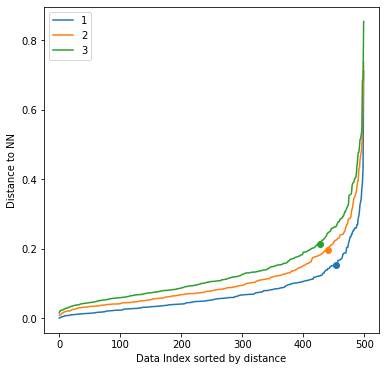

In [67]:
# Code provided by the professor
df = data.copy()
neighbors = 3
nbrs = NearestNeighbors(n_neighbors= neighbors + 1).fit(df)
distances, indices = nbrs.kneighbors(df)
distances= np.sort(distances, axis= 0)


opt_esp_minpts = np.empty((0, 2))
plt.figure(figsize= (6, 6))
for n in np.arange(1, neighbors + 1):
    
    lndf = np.linspace(start= distances[0, n], stop= distances[-1, n], num= int(distances.shape[0]))

    distA = np.concatenate([np.arange(1, distances.shape[0] + 1) / distances.shape[0], distances[:, n]]).reshape(2, -1).T
    distB = np.concatenate([np.arange(1, lndf.shape[0] + 1) / lndf.shape[0], lndf]).reshape(2, -1).T

    all2all = cdist(XA = distA, XB= distB)
    idx_opt = all2all.min(axis= 1).argmax()
    
    opt_esp_minpts = np.vstack([opt_esp_minpts, np.array([n, distances[idx_opt, n]])]) 
    
    plt.plot(distances[:, n], label= n)
    plt.scatter(x= idx_opt, y= distances[idx_opt, n])
    
plt.legend()
plt.xlabel('Data Index sorted by distance')
plt.ylabel('Distance to NN')
plt.show()

In [68]:
min_samples = int(opt_esp_minpts[-1, 0])
min_samples

3

In [69]:
eps = opt_esp_minpts[-1, 1]
eps

0.21318468983485075

Number of predicted clusters: 5


[Text(0.5, 1.0, 'DBSCAN Clustering')]

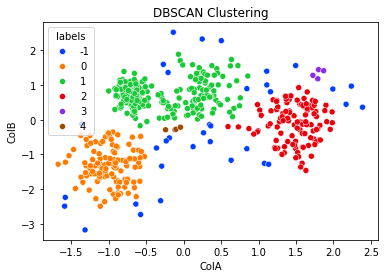

In [70]:
dbscan = DBSCAN(min_samples=min_samples, eps=eps, metric="euclidean")
dbscan_clusters = dbscan.fit_predict(data)
data_res = data.copy()
data_res["labels"] = dbscan_clusters
labels = dbscan.labels_
# Number of clusters, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print ("Number of predicted clusters: " + str(n_clusters_))

sns.scatterplot(data=data_res,x="ColA",y='ColB', hue='labels', palette='bright').set(title="DBSCAN Clustering")

It can be seen that, according to a clustering technique that was not passed a number of clusters as a parameter, the appropiate number of clusters is 9, with some outliers. 

## Agglomerative Hierarchical

### Choosing K

In [71]:
# Davies-Bouldin Index
for k in np.arange(2, 10):
    hc = AgglomerativeClustering(n_clusters = k, metric = 'euclidean', linkage = 'ward')
    hc.fit(data)
    print(f'k: {k}\nDBI: {davies_bouldin_score(X= data[["ColA", "ColB"]], labels= hc.labels_)    }')


k: 2
DBI: 0.701330325012372
k: 3
DBI: 0.6191559422333258
k: 4
DBI: 0.8394670126720063
k: 5
DBI: 0.7565459829986633
k: 6
DBI: 0.7746488794469951
k: 7
DBI: 0.8033879395644421
k: 8
DBI: 0.7929956217813429
k: 9
DBI: 0.7931010751603593


In [72]:
# Calinski-Harabasz score
cluster_numbers = np.arange(2,10)
chs = []
for k in cluster_numbers:
    hc = AgglomerativeClustering(n_clusters = k, metric = 'euclidean', linkage = 'ward')
    hc.fit(data)
    

    score = calinski_harabasz_score(X= data[["ColA", "ColB"]], labels = hc.labels_)
    chs.append(score)
    print(f'k: {k}\nDBI: {score}')

k: 2
DBI: 426.6465262263014
k: 3
DBI: 771.937540296005
k: 4
DBI: 710.5584287387069
k: 5
DBI: 667.0947670089653
k: 6
DBI: 667.634896400436
k: 7
DBI: 669.1211914478923
k: 8
DBI: 651.3495718240117
k: 9
DBI: 649.8143012791862


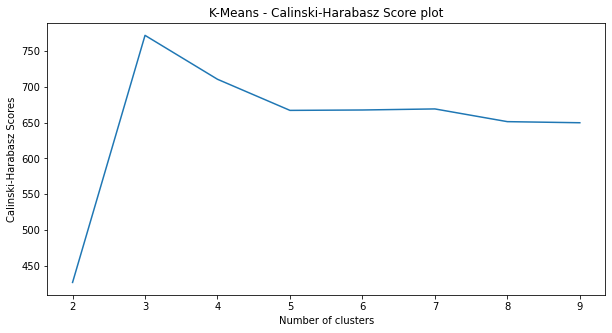

In [73]:
plt.figure(figsize=(10,5))
plt.plot(cluster_numbers,chs)
plt.title("K-Means - Calinski-Harabasz Score plot")
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Scores')
plt.show()

From the tests above, it can be seen that the right number of clusters for Agglomerative Clustering is 3

In [74]:
n_clusters = 3

[Text(0.5, 1.0, 'Agglomerative Clustering')]

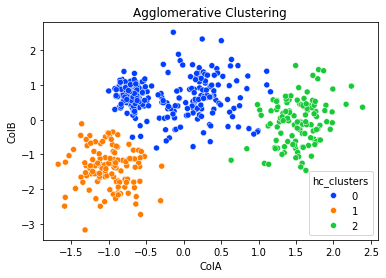

In [75]:
data_res = data.copy()
hc = AgglomerativeClustering(n_clusters = n_clusters, metric = 'euclidean', linkage = 'ward')
hc_clusters = hc.fit_predict(data_res)
data_res['hc_clusters'] = hc_clusters

sns.scatterplot(data=data_res,x="ColA",y='ColB', hue='hc_clusters',palette='bright').set(title="Agglomerative Clustering")

## Questions
* What method(s) did you use to identify an appropriate value for K? Why did you select this method(s)?

- Elbow method: A very graphical, simple method to determine the number of clusters
- Davies-Bouldin Index: It is a metric to measure the quality of the clusters, and by using different numbers of clusters, it can be used to see which amount of clusters provides the best score
- Calinski-Harabasz score: Similar reasoning for the above method
- Silhouette score: Used to visually assess the number of clusters

* What value did you select for K? Does your EDA support this choice?

A different number of clusters was chosen for each method: 

* Agglomerative Clustering: 3
* DBSCAN: 5
* GMM: 4
* K means : 3

A basic scatterplot of the data shows what looks like 4 clusters, so what can be visually assessed is different from what the methods say, but the methods are more reliable for data this dispersed. 

* Why is the algorithm that you selected for your final clustering model the best choice among those you evaluated?

After running all the clustering methods, I believe that the best result is GMM, with 4 clusters. 
However, every algorithm shows similar results, except for DBSCAN with 5 clusters. But from these 5 clusters, only 3 are big clusters, 2 are small clusters caused by coincidence, and some outliers.

# Problem 5. Comparing Algorithms

Compare the relative strengths and weaknesses of the clustering methods listed in Problem 3. Include your observations in a table form.

# Problem 6. Dimensionality Reduction

In [76]:
df = pd.read_csv("network.csv")
data = df.copy()

In [77]:
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108499 entries, 0 to 108498
Data columns (total 33 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   day                                   108499 non-null  object 
 1   BTS_ID                                108499 non-null  object 
 2   RRC_Conn_Release_due_to_S1_Link_Fail  108499 non-null  float64
 3   Max_Num_RRC_Conn_User                 108499 non-null  float64
 4   Mean_RRC_Conn_Setup_Time_ms           108499 non-null  float64
 5   Avg_PRACH_Usage_per_Second            108499 non-null  float64
 6   FDD_Cell_DL_Avg_Agg_Thruput_Mbps      108499 non-null  float64
 7   FDD_Cell_UL_Avg_Agg_Thruput_Mbps      108499 non-null  float64
 8   FDD_Cell_DL_MAC_Data_Volume_MB        108499 non-null  float64
 9   FDD_Cell_UL_MAC_Data_Volume_MB        108499 non-null  float64
 10  Avg_CQI                               108499 non-null  float64
 11  

day BTS_ID  RRC_Conn_Release_due_to_S1_Link_Fail  \
0  2020-12-16   10-1                                   0.0   
1  2020-12-16   10-2                                   0.0   
2  2020-12-16  100-1                                   0.0   
3  2020-12-16  100-2                                   0.0   
4  2020-12-16  100-3                                   0.0   

   Max_Num_RRC_Conn_User  Mean_RRC_Conn_Setup_Time_ms  \
0              10.666667                    10.181750   
1               2.125000                     1.666792   
2              24.083333                    20.737667   
3               8.500000                     7.644583   
4               8.333333                     4.672417   

   Avg_PRACH_Usage_per_Second  FDD_Cell_DL_Avg_Agg_Thruput_Mbps  \
0                    0.598113                         15.432917   
1                    0.093437                          6.310417   
2                    1.367511                         14.935417   
3                    1.916562                          5.789167   
4                    0.384918                          8.597917   

   FDD_Cell_UL_Avg_Agg_Thruput_Mbps  FDD_Cell_DL_MAC_Data_Volume_MB  \
0                          0.827500                    56828.471394   
1                          0.730000                     1805.221844   
2                          1.695000                   136063.358720   
3                          0.841250                    12039.323018   
4                          1.043333                    56530.843458   

   FDD_Cell_UL_MAC_Data_Volume_MB  ...  DL_64QAM_Modulation_Scheme_Usage_Pct  \
0                     3800.954458  ...                             83.976446   
1                      332.183693  ...                             62.255030   
2                    15646.961508  ...                             69.792755   
3                     1778.473769  ...                             28.072433   
4                     5806.853017  ...                             50.873659   

   UL_16QAM_Modulation_Scheme_Usage_Pct  FDD_ERAB_Setup_Success_Pct  \
0                             45.754344                   99.971157   
1                             42.497237                   99.929478   
2                             67.834631                   99.440905   
3                             54.548570                   99.263804   
4                             77.707216                   99.775470   

   DL 64QAM vs UL 16 ratio  Avg CQI to DL 64QAM ratio  DL PRB vs UL PRB ratio  \
0                 1.835376                   0.154557                1.210074   
1                 1.464919                   0.178633                0.755029   
2                 1.028866                   0.162624                2.025333   
3                 0.514632                   0.311248                1.589387   
4                 0.654684                   0.190177                2.849405   

   MIMO_Usage_Pct  RSSI_Avg_dBm  PRACH_Avg_NI_dBm  Power_DL_Avg_mw  
0       97.925378    -69.812267       -119.040736     15386.552083  
1       92.218066    -86.227163       -115.395241      7913.541667  
2       82.093341    -91.928520       -120.045476     16587.656250  
3       76.158130    -98.385215       -120.045476      6388.468750  
4       66.569430    -96.467722       -120.045476     10989.072917  

[5 rows x 33 columns]

In [78]:
data.describe().T

count          mean           std  \
RRC_Conn_Release_due_to_S1_Link_Fail  108499.0     41.211228    632.870359   
Max_Num_RRC_Conn_User                 108499.0     17.203139     15.166520   
Mean_RRC_Conn_Setup_Time_ms           108499.0     31.807346    152.401176   
Avg_PRACH_Usage_per_Second            108499.0      0.964043      3.177729   
FDD_Cell_DL_Avg_Agg_Thruput_Mbps      108499.0      8.885745      5.958099   
FDD_Cell_UL_Avg_Agg_Thruput_Mbps      108499.0      1.300382      0.745492   
FDD_Cell_DL_MAC_Data_Volume_MB        108499.0  49104.803027  59236.048562   
FDD_Cell_UL_MAC_Data_Volume_MB        108499.0   6930.623418   7198.936599   
Avg_CQI                               108499.0     10.806676      1.808540   
FDD_RRC_Est_Success_Pct               108499.0     99.527394      1.000186   
FDD_RRC_Re_Est_Success_Pct            108499.0     56.806345     24.506069   
RRC_Reconfiguration_Success_Pct       108499.0     98.909748      1.753213   
UE_Context_Est_Success_Pct            108499.0     98.747025      2.140857   
RRC_Drop_Pct                          108499.0      1.705393      3.051044   
FDD_ERAB_Drop_Pct                     108499.0      0.720154      2.232997   
FDD_ERAB_Block_Pct                    108499.0      0.000003      0.000367   
ERAB_Block_in_HO_Pct                  108499.0      0.122301      2.494600   
UL_PRB_Util_Pct                       108499.0     21.513267     12.814369   
DL_PRB_Util_Pct                       108499.0     34.894538     28.167297   
Cell_UL_BLER_Pct                      108499.0      6.490781      2.763760   
Cell_DL_BLER_Pct                      108499.0     10.557836      1.750967   
DL_64QAM_Modulation_Scheme_Usage_Pct  108499.0     51.922329     24.508872   
UL_16QAM_Modulation_Scheme_Usage_Pct  108499.0     53.414500     24.701615   
FDD_ERAB_Setup_Success_Pct            108499.0     98.784027      2.148936   
DL 64QAM vs UL 16 ratio               108499.0      1.432326      6.119849   
Avg CQI to DL 64QAM ratio             108499.0      0.429269      6.403240   
DL PRB vs UL PRB ratio                108499.0      1.488088      0.830787   
MIMO_Usage_Pct                        108499.0     74.599737     19.870653   
RSSI_Avg_dBm                          108499.0    -95.005311      7.388712   
PRACH_Avg_NI_dBm                      108499.0   -117.816756      3.826271   
Power_DL_Avg_mw                       108499.0  13010.784641   8379.040187   

                                             min          25%           50%  \
RRC_Conn_Release_due_to_S1_Link_Fail    0.000000     0.000000      0.000000   
Max_Num_RRC_Conn_User                   0.000000     7.333333     13.625000   
Mean_RRC_Conn_Setup_Time_ms             0.000000     6.092625     14.019167   
Avg_PRACH_Usage_per_Second              0.000000     0.194172      0.412789   
FDD_Cell_DL_Avg_Agg_Thruput_Mbps        0.000000     4.839167      7.544583   
FDD_Cell_UL_Avg_Agg_Thruput_Mbps        0.000000     0.781667      1.215417   
FDD_Cell_DL_MAC_Data_Volume_MB          0.000000  4749.499157  25945.904354   
FDD_Cell_UL_MAC_Data_Volume_MB          0.000000  1205.473163   4618.594468   
Avg_CQI                                 0.000000     9.850000     10.979167   
FDD_RRC_Est_Success_Pct                 0.000000    99.485097     99.742848   
FDD_RRC_Re_Est_Success_Pct              0.000000    38.558997     57.933579   
RRC_Reconfiguration_Success_Pct         0.000000    98.780465     99.365595   
UE_Context_Est_Success_Pct              0.000000    98.559778     99.335846   
RRC_Drop_Pct                            0.000000     0.378788      0.814188   
FDD_ERAB_Drop_Pct                       0.000000     0.109723      0.252406   
FDD_ERAB_Block_Pct                      0.000000     0.000000      0.000000   
ERAB_Block_in_HO_Pct                    0.000000     0.000000      0.000000   
UL_PRB_Util_Pct                         2.421861    11.215633     18.381751   
DL_PRB_Util_Pct                         2.5

In [79]:
data.isna().sum()

day                                     0
BTS_ID                                  0
RRC_Conn_Release_due_to_S1_Link_Fail    0
Max_Num_RRC_Conn_User                   0
Mean_RRC_Conn_Setup_Time_ms             0
Avg_PRACH_Usage_per_Second              0
FDD_Cell_DL_Avg_Agg_Thruput_Mbps        0
FDD_Cell_UL_Avg_Agg_Thruput_Mbps        0
FDD_Cell_DL_MAC_Data_Volume_MB          0
FDD_Cell_UL_MAC_Data_Volume_MB          0
Avg_CQI                                 0
FDD_RRC_Est_Success_Pct                 0
FDD_RRC_Re_Est_Success_Pct              0
RRC_Reconfiguration_Success_Pct         0
UE_Context_Est_Success_Pct              0
RRC_Drop_Pct                            0
FDD_ERAB_Drop_Pct                       0
FDD_ERAB_Block_Pct                      0
ERAB_Block_in_HO_Pct                    0
UL_PRB_Util_Pct                         0
DL_PRB_Util_Pct                         0
Cell_UL_BLER_Pct                        0
Cell_DL_BLER_Pct                        0
DL_64QAM_Modulation_Scheme_Usage_P

## Part 1

In [80]:
# day column is changed to datetime type
data["day"] = pd.to_datetime(data["day"])

In [81]:
# Data is filtered to include only the last day. From over 100k rows, only 593 are left
data = data[data["day"] == "2021-06-13"].copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 593 entries, 107906 to 108498
Data columns (total 33 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   day                                   593 non-null    datetime64[ns]
 1   BTS_ID                                593 non-null    object        
 2   RRC_Conn_Release_due_to_S1_Link_Fail  593 non-null    float64       
 3   Max_Num_RRC_Conn_User                 593 non-null    float64       
 4   Mean_RRC_Conn_Setup_Time_ms           593 non-null    float64       
 5   Avg_PRACH_Usage_per_Second            593 non-null    float64       
 6   FDD_Cell_DL_Avg_Agg_Thruput_Mbps      593 non-null    float64       
 7   FDD_Cell_UL_Avg_Agg_Thruput_Mbps      593 non-null    float64       
 8   FDD_Cell_DL_MAC_Data_Volume_MB        593 non-null    float64       
 9   FDD_Cell_UL_MAC_Data_Volume_MB        593 non-null    float64       
 10 

In [82]:
# Day column is dropped and BTS_ID column is saved to an external variable
BTS_ID = data[["BTS_ID"]]
BTS_ID = BTS_ID.reset_index()
data = data.drop(columns=["day", "BTS_ID"]).copy()

In [83]:
# Data is scaled
std_scaler = StandardScaler()
data = pd.DataFrame(std_scaler.fit_transform(data))

In [84]:
# Data dimensionality is reduced
pca_2 = PCA(n_components=2, random_state=42).fit(data)
pca_data = pca_2.transform(data)
pca_data

array([[ 0.66555402, -0.55807498],
       [ 0.13542909, -0.45650603],
       [ 1.64634518, -0.24188268],
       ...,
       [-0.97310967,  6.50883279],
       [-1.54031334, -2.24294076],
       [-2.75011419, -1.74595762]])

In [85]:
# The BTS_ID variable is added back
data = pd.DataFrame(data = pca_data, columns=["ColA", "ColB"])
data = pd.concat([data, BTS_ID], axis=1)

In [86]:
# Plotting the data
customdata = np.stack((data["BTS_ID"]), axis=-1)
fig = px.scatter(data_frame=data, x = "ColA", y = "ColB")#, hover_data=["ColA", "ColB", "BTS_ID"])
hovertemplate = ('BTS_ID: %{customdata}<br>' + 
    'ColA: %{x} <br>' + 
    'ColB: %{y}')
fig.update_traces(customdata=customdata, hovertemplate=hovertemplate)
fig.show()

## Part 2

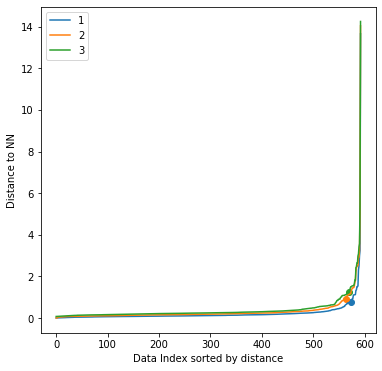

In [87]:
# Code provided by the professor
temp_data = data[["ColA", "ColB"]].copy()
neighbors = 3
nbrs = NearestNeighbors(n_neighbors= neighbors + 1).fit(temp_data)
distances, indices = nbrs.kneighbors(temp_data)
distances= np.sort(distances, axis= 0)


opt_esp_minpts = np.empty((0, 2))
plt.figure(figsize= (6, 6))
for n in np.arange(1, neighbors + 1):
    
    lndf = np.linspace(start= distances[0, n], stop= distances[-1, n], num= int(distances.shape[0]))

    distA = np.concatenate([np.arange(1, distances.shape[0] + 1) / distances.shape[0], distances[:, n]]).reshape(2, -1).T
    distB = np.concatenate([np.arange(1, lndf.shape[0] + 1) / lndf.shape[0], lndf]).reshape(2, -1).T

    all2all = cdist(XA = distA, XB= distB)
    idx_opt = all2all.min(axis= 1).argmax()
    
    opt_esp_minpts = np.vstack([opt_esp_minpts, np.array([n, distances[idx_opt, n]])]) 
    
    plt.plot(distances[:, n], label= n)
    plt.scatter(x= idx_opt, y= distances[idx_opt, n])
    
plt.legend()
plt.xlabel('Data Index sorted by distance')
plt.ylabel('Distance to NN')
plt.show()

In [88]:
min_samples = int(opt_esp_minpts[-1, 0])
min_samples

3

In [89]:
eps = opt_esp_minpts[-1, 1]
eps

1.2415091019388496

Number of predicted clusters: 1


[Text(0.5, 1.0, 'DBSCAN Clustering')]

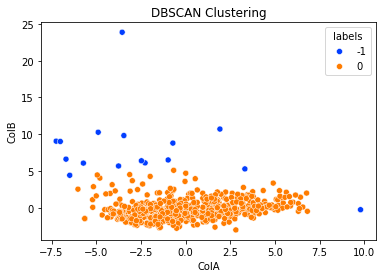

In [90]:
dbscan = DBSCAN(eps=eps, metric='euclidean', min_samples=min_samples)
dbscan_clusters = dbscan.fit_predict(data[["ColA", "ColB"]])
data_res = data[["ColA", "ColB"]].copy()
data_res["labels"] = dbscan_clusters
labels = dbscan.labels_
# Number of clusters, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print ("Number of predicted clusters: " + str(n_clusters_))

sns.scatterplot(data=data_res,x="ColA",y='ColB', hue='labels', palette='bright').set(title="DBSCAN Clustering")

In [91]:
print("Outliers")
data_res[data_res["labels"] == -1]

Outliers


ColA       ColB  labels
11  -3.451528   9.828003      -1
41  -2.264220   6.109792      -1
91   9.791050  -0.254133      -1
138 -7.240263   9.065111      -1
139 -6.690594   6.621169      -1
170 -3.750051   5.689427      -1
172 -3.546830  23.869528      -1
187 -2.469397   6.395379      -1
202  3.319060   5.292523      -1
287 -6.481695   4.426272      -1
313 -5.716874   6.082256      -1
320 -4.887989  10.277057      -1
356 -0.709828   8.802879      -1
459  1.922481  10.711338      -1
495 -7.009612   9.021826      -1
590 -0.973110   6.508833      -1

In [92]:
data["labels"] = data_res.apply(lambda row: -1 if row["labels"] == -1 else 0, axis=1)

In [93]:
# Plotting the data
customdata = np.stack((data["BTS_ID"], data["labels"]), axis=-1)
fig = px.scatter(data_frame=data, x = "ColA", y = "ColB", color="labels")#, hover_data=["ColA", "ColB", "BTS_ID"])
hovertemplate = ('BTS_ID: %{customdata[0]}<br>' + 
    'ColA: %{x} <br>' + 
    'ColB: %{y} <br>' + 
    "labels: %{customdata[1]}"
    '<extra></extra>')
fig.update_traces(customdata=customdata, hovertemplate=hovertemplate)
fig.show()

## Part 3

In [94]:
# Now perform the same steps, but in every date except 2021-06-13
data = df.copy()
data["day"] = pd.to_datetime(data["day"])
data = data[data["day"] != "2021-06-13"].copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107906 entries, 0 to 107905
Data columns (total 33 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   day                                   107906 non-null  datetime64[ns]
 1   BTS_ID                                107906 non-null  object        
 2   RRC_Conn_Release_due_to_S1_Link_Fail  107906 non-null  float64       
 3   Max_Num_RRC_Conn_User                 107906 non-null  float64       
 4   Mean_RRC_Conn_Setup_Time_ms           107906 non-null  float64       
 5   Avg_PRACH_Usage_per_Second            107906 non-null  float64       
 6   FDD_Cell_DL_Avg_Agg_Thruput_Mbps      107906 non-null  float64       
 7   FDD_Cell_UL_Avg_Agg_Thruput_Mbps      107906 non-null  float64       
 8   FDD_Cell_DL_MAC_Data_Volume_MB        107906 non-null  float64       
 9   FDD_Cell_UL_MAC_Data_Volume_MB        107906 non-null  float64  

In [95]:
# Day column is dropped and BTS_ID column is saved to an external variable
BTS_ID = data[["BTS_ID"]]
BTS_ID = BTS_ID.reset_index()
data = data.drop(columns=["day", "BTS_ID"]).copy()
# Data is scaled
std_scaler = StandardScaler()
data = pd.DataFrame(std_scaler.fit_transform(data))
# Data dimensionality is reduced
pca_2 = PCA(n_components=2, random_state=42).fit(data)
pca_data = pca_2.transform(data)
# The BTS_ID variable is added back
data = pd.DataFrame(data = pca_data, columns=["ColA", "ColB"])
data = pd.concat([data, BTS_ID], axis=1)
data = data.drop(["index"], axis=1)

In [96]:
center = np.array((0,0))
data["euclidean"] = data.apply(lambda x: np.linalg.norm(np.array((x["ColA"], x["ColB"])) - center), axis=1)

In [97]:
means = data.groupby("BTS_ID")["euclidean"].mean()
data["mean_BTS_euclidean"] = data.apply(lambda x: means[x["BTS_ID"]] ,axis=1)

In [98]:
# Compute the distance from the center of the plot for each BTS_ID using the "2021-06-13" data. 
data_13 = df.copy()
data_13["day"] = pd.to_datetime(data_13["day"])
data_13 = data_13[data_13["day"] == "2021-06-13"].copy()

In [99]:
# Day column is dropped and BTS_ID column is saved to an external variable
BTS_ID = data_13[["BTS_ID"]]
BTS_ID = BTS_ID.reset_index()
data_13 = data_13.drop(columns=["day", "BTS_ID"]).copy()
# Data is scaled
std_scaler = StandardScaler()
data_13 = pd.DataFrame(std_scaler.fit_transform(data_13))
# Data dimensionality is reduced
pca_2 = PCA(n_components=2, random_state=42).fit(data_13)
pca_data = pca_2.transform(data_13)
# The BTS_ID variable is added back
data_13 = pd.DataFrame(data = pca_data, columns=["ColA", "ColB"])
data_13 = pd.concat([data_13, BTS_ID], axis=1)
data_13 = data_13.drop(["index"], axis=1)

In [100]:
center = np.array((0,0))
data_13["euclidean"] = data_13.apply(lambda x: np.linalg.norm(np.array((x["ColA"], x["ColB"])) - center), axis=1)

In [101]:
# Duplicates are deleted, as their average would be the same
data_13 = data_13.drop_duplicates(["BTS_ID"])
data_13

ColA      ColB BTS_ID  euclidean
0    0.665554 -0.558075   10-1   0.868568
1    0.135429 -0.456506   10-2   0.476171
2    1.646345 -0.241883  100-1   1.664019
3   -2.181987  0.413157  100-2   2.220758
4   -1.122743 -0.155742  100-3   1.133493
..        ...       ...    ...        ...
588 -2.390552 -0.164755  944-3   2.396223
589 -0.851619  2.643008  950-1   2.776823
590 -0.973110  6.508833  950-2   6.581174
591 -1.540313 -2.242941  952-7   2.720909
592 -2.750114 -1.745958  952-8   3.257529

[593 rows x 4 columns]

In [102]:
average_data = data[["BTS_ID", "mean_BTS_euclidean"]].copy()
average_data.reset_index
average_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107906 entries, 0 to 107905
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   BTS_ID              107906 non-null  object 
 1   mean_BTS_euclidean  107906 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.6+ MB


In [103]:
# Duplicates are deleted, as their average would be the same
average_data = average_data.drop_duplicates(["BTS_ID"])

In [104]:
analysis_data = average_data.copy()
analysis_data = analysis_data.merge(data_13[["BTS_ID" ,"euclidean"]], on="BTS_ID")
analysis_data

BTS_ID  mean_BTS_euclidean  euclidean
0     10-1            2.144963   0.868568
1     10-2            1.683660   0.476171
2    100-1            2.237996   1.664019
3    100-2            2.066586   2.220758
4    100-3            1.414100   1.133493
..     ...                 ...        ...
588  944-3            3.134148   2.396223
589  950-1            2.586101   2.776823
590  950-2            3.347709   6.581174
591  952-7            2.688604   2.720909
592  952-8            2.886000   3.257529

[593 rows x 3 columns]

In [105]:
# Differences are detected
analysis_data["status"] = analysis_data.apply(lambda x: "Worse" if x["euclidean"] > x["mean_BTS_euclidean"] else "Better" , axis = 1)
analysis_data

BTS_ID  mean_BTS_euclidean  euclidean  status
0     10-1            2.144963   0.868568  Better
1     10-2            1.683660   0.476171  Better
2    100-1            2.237996   1.664019  Better
3    100-2            2.066586   2.220758   Worse
4    100-3            1.414100   1.133493  Better
..     ...                 ...        ...     ...
588  944-3            3.134148   2.396223  Better
589  950-1            2.586101   2.776823   Worse
590  950-2            3.347709   6.581174   Worse
591  952-7            2.688604   2.720909   Worse
592  952-8            2.886000   3.257529   Worse

[593 rows x 4 columns]

In [106]:
# Sites that have gotten better
analysis_data[analysis_data["status"] == "Better"]

BTS_ID  mean_BTS_euclidean  euclidean  status
0     10-1            2.144963   0.868568  Better
1     10-2            1.683660   0.476171  Better
2    100-1            2.237996   1.664019  Better
4    100-3            1.414100   1.133493  Better
5    100-4            2.501134   0.987730  Better
..     ...                 ...        ...     ...
582  942-2            2.959461   2.681187  Better
584  943-2            2.345726   1.885891  Better
585  943-3            2.707811   2.492828  Better
587  944-2            1.043570   0.856658  Better
588  944-3            3.134148   2.396223  Better

[302 rows x 4 columns]

In [107]:
# Average of difference
mean(analysis_data[analysis_data["status"] == "Better"].apply(lambda x: abs(x["mean_BTS_euclidean"] - x["euclidean"]) , axis = 1))

0.596973924524244

In [108]:
# Sites that have gotten worse
analysis_data[analysis_data["status"] == "Worse"]

BTS_ID  mean_BTS_euclidean  euclidean status
3      100-2            2.066586   2.220758  Worse
9    10119-2            1.612679   2.627777  Worse
10   10119-3            0.845899   1.097373  Worse
11   10238-1            7.838555  10.416463  Worse
13   10238-3            2.286858   2.452146  Worse
..       ...                 ...        ...    ...
586    944-1            1.246872   1.970790  Worse
589    950-1            2.586101   2.776823  Worse
590    950-2            3.347709   6.581174  Worse
591    952-7            2.688604   2.720909  Worse
592    952-8            2.886000   3.257529  Worse

[291 rows x 4 columns]

In [109]:
# Average of difference
mean(analysis_data[analysis_data["status"] == "Worse"].apply(lambda x: abs(x["mean_BTS_euclidean"] - x["euclidean"]) , axis = 1))

0.6999028538128642

## Question
Are the engineers making progress with the system performance?

If we take only the total number of sites that have improved, then yes, as 302 sites have gotten better while only 291 sites have gotten worse.
But if we take the averages of differences in the distances, we can see that the ones that have improved have done so with an average of only 0.59697, and the sites that have gotten worse have done so with an average of 0.69990

In [110]:
# Commented out as it consumes so much memory the notebook crashes
# dbscan = DBSCAN(1, metric='euclidean', min_samples=2, n_jobs = -2)
# dbscan_clusters = dbscan.fit_predict(data[["ColA", "ColB"]])
# data_res = data[["ColA", "ColB"]].copy()
# data_res["labels"] = dbscan_clusters
# labels = dbscan.labels_
# # Number of clusters, ignoring noise if present.
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# print ("Number of predicted clusters: " + str(n_clusters_))

# sns.scatterplot(data=data_res,x="ColA",y='ColB', hue='labels', palette='bright').set(title="DBSCAN Clustering")